# Training Neural Networks with PyTorch
Copyright 2022, LEAKY.AI LLC

This is Assignment 4 for the Introduction to Deep Learning with PyTorch course (www.leaky.ai). 

### In this assignment you will:
- Build and train a neural network from scratch to forecast fictitious Teddy Bear sales over the course of a year using Google Colab and PyTorch
- Compare how different loss functions, optimizers, learning rates and other parameters affects the training process
- Track both the training loss and validation loss during the training process to ensure the model is generalizing
- Experiment with different model types to see how they affect the final test dataset loss score
- Plot the target output vs the actual output of the model after training in order to visualize the model’s performance

### To get started:
1.	Open up a web browser (preferable Chrome)
2.	Copy the Project GitHub Link: https://github.com/LeakyAI/PyTorch-Overview
3.	Head over to Google Colab (https://colab.research.google.com)
4.	Load the notebook: Training and Inference - Start Here.ipynb
5.	Replace the [TBD]'s with your own code
6.	Execute the notebook after completing each cell and check your answers using the solution notebook


Don't forget to print out and have your <b>Leaky.ai PyTorch Cheatsheet</b> handy when tackling this assignment.  You can find it on the right-hand side of the the course home landing page in the Resource section.

Good luck!

## Import the PyTorch Libraries and Set Random Seeds
Start by importing our PyTorch libraries, setting our random seed to get reproducible results and then verifying our PyTorch version.

In [1]:
# Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import some match and visual libraries we will need
import math, random
import matplotlib.pyplot as plt

# Set our seeds to get reproducible results
torch.manual_seed(6)
random.seed(6)

## Create Synthetic Teddy Bear Sales Dataset
To begin, we will use our Teddy Bear sales data from the earlier assingment. 

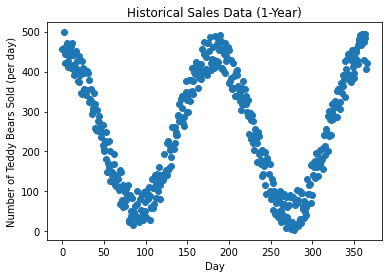

In [2]:
# Create a random synthentic sales dataset for Teddy Bear sales over 1 year
day = torch.linspace(0, 365, 500)
teddyBears = (100*(2*torch.cos(day*4*math.pi/365)+torch.rand(500))+200)

# Display our Teddy Bear sales data for year 1
plt.scatter(day, teddyBears)
plt.xlabel("Day")
plt.ylabel("Number of Teddy Bears Sold (per day)")
plt.title("Historical Sales Data (1-Year)")
plt.show()

## Normalize the Dataset
Networks train better if inputs are small (~-1..1) so we typically scale the inputs and desired output accordingly.  Two common ways to scale:
- Min Max Normalization – rescale values to a range of 0..1 using max and min values
- Standardization – rescale with 0 mean and 1 std. deviation, best if outliers

Since the dataset in this case does not have significant issues withoutliers, we will simply apply normalization.

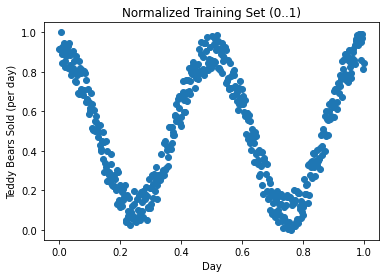

In [3]:
# Prepare our normalized training set 
# Noramlized Value = (Input - Min) / (Max - Min)
dayMax=day.max()
dayMin=day.min()
dayNormalized = (day - dayMin) / (dayMax-dayMin)
teddyBearsMax = teddyBears.max()
teddyBearsMin = teddyBears.min()
teddyBearsNormalized = (teddyBears - teddyBearsMin) / (teddyBearsMax - teddyBearsMin)

# Display normalized values for our training data
plt.scatter(dayNormalized, teddyBearsNormalized)
plt.title("Normalized Training Set (0..1)")
plt.xlabel("Day")
plt.ylabel("Teddy Bears Sold (per day)")
plt.show() 

## Wrap Dataset in PyTorch's Dataset and Dataloader Class
PyTorch offers a Dataset class and a Dataloader class that speeds up the process of batching our data.  Below you will implement a PyTorch dataset using the Teddy Bear sales data above and then pass that to the DataLoader class which will automatically create our batches for training.

### Add a Batch Dimension
When training, our dimensions for the input data must be [batch, day] and our output target must be [batch, teddyBearsSold].  We will use the unsqueeze function to add a dimension (dim=1) to each of our tensors.

In [4]:
# Assign our input x to our normalized day values
# Assign our desired output y (target) to our normalized teddy bear sales
# Finally, add a batch dimension using the unsqueeze tensor function
# Note:  training will require the input and output to specify the batch index so 
#        we need to add that dimension to our tensor (e.g. [day] -> [batch, day])
x=torch.unsqueeze(dayNormalized, dim=1)
y=torch.unsqueeze(teddyBearsNormalized,dim=1)

### Split our data into Training, Validation and Testing Sets
Typically you can use the 80%, 10%, 10% split rule to create the three datasets from the original data.  Lots of ways to accomplish this, here you will use a simple indexing technique to slice the data into the three sets.

In [5]:
# Create the index splits for training, validation and test
# Import numpy for shuffling index values
import numpy as np

# Start by finding the total number of items in the original dataset
# using the len function
total = len(x)

# Build a list of indicies and shuffle them randomly
# Indicies should be in range of the length of x
indices = list(range(total))

# Shuffle the indicies
np.random.shuffle(indices)

# Allocate 80% of the data for the training set
# (10% for test set and 10% for validation set)
trainingPercent = .8

# Calculate the first split point so that x[:split1] will be your training set
split1 = int(total*trainingPercent)

# Calculate your 2nd split point so that x[split1:split2] will be
# your validation set and x[split2:] will be your testing set
split2 = int(((total - split1)/2)+split1)

In [6]:
# Create our a simple dataset using the PyTorch dataset class
class Dataset(torch.utils.data.Dataset):
  def __init__(self, x, y):
        # Initialize both x and y
        self.x = x
        self.y = y

  def __len__(self):
        # Total number of samples in the dataset
        return len(self.y)

  def __getitem__(self, index):
        # Return the data at location index
        x=self.x[index]
        y=self.y[index]
        return x,y

# Instantiate the three datasets
train_set = Dataset(x[indices[:split1]], y[indices[:split1]])
val_set = Dataset(x[indices[split1:split2]], y[indices[split1:split2]])
test_set = Dataset(x[indices[split2:]], y[indices[split2:]])

# Create dataloaders for each dataset
# For the training set, make sure to set shuffle to true
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=50,
                                           shuffle=True,
                                           num_workers=0)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=50,
                                         shuffle=False,
                                         num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=50,
                                          shuffle=False,
                                          num_workers=0)

In [7]:
print (f"Train Loader - Total Number of Mini-Batches: {len(train_loader)}")
print (f"Train Loader - Total Size of Dataset: {len(train_loader.sampler)}")
print (f"Validation Loader - Total Number of Mini-Batches: {len(val_loader)}")
print (f"Validation Loader - Total Size of Dataset: {len(val_loader.sampler)}")
print (f"Test Loader - Total Number of Mini-Batches: {len(test_loader)}")
print (f"Test Loader - Total Size of Dataset: {len(test_loader.sampler)}")

Train Loader - Total Number of Mini-Batches: 8
Train Loader - Total Size of Dataset: 400
Validation Loader - Total Number of Mini-Batches: 1
Validation Loader - Total Size of Dataset: 50
Test Loader - Total Number of Mini-Batches: 1
Test Loader - Total Size of Dataset: 50


## Create Training Code and Display Model
Since we will be training multiple times, we will create a function to train our model and a function to display the model's prediction vs. our training set.

In [8]:
# scoreModel:  Returns to the average loss given a criterion
#              on the entire dataset in the loader
@torch.no_grad() 
def scoreModel(model, loader, criterion):
    model.eval()                               # Set the model to inference mode
    lossTotal = 0.0                            # Initialize the total loss
    
    for x,y in loader:
        pred = model(x)                        # Single forward pass
        loss = criterion(pred, y)              # Calculate the average loss for the batch
        lossTotal+=loss.item()*x.size(0)       # Add the average loss adjusting for size of batch
        
    lossAvg = lossTotal/len(loader.sampler)    # Calculate the average loss for the entire dataset
    return lossAvg

In [9]:
# Train the Neural Network using Mini-Batches
# Purpose:  This function will train the neural network on the
#           given training dataset for x number of epochs
# Inputs:
#    epochs:     The total number of training epochs
#    model:      The neural network definition
#    train_loader: dataloader holding our training data
#    val_loader:  dataloader for the validation dataset
#    criterion:  Loss function used during training
#    optimizer:  Algorithm for determining weights
def train(epochs, model, train_loader, val_loader, test_loader, criterion, optimizer):

    # Set the model to training mode (enable dropout, batch norm stats etc.)
    minValLoss = float('inf')
    model.train()
    
    # Train model for epochs number of epochs (full pass of training set)
    for epoch in range(epochs):
        
        # Track loss over the entire epoch
        totalLoss = 0
        for x, y in train_loader:
            
            # Perform a single forward pass with a mini-batch and calculate loss
            y_pred = model(x)    
            loss = criterion(y_pred, y) 
            totalLoss+=loss.item()*x.size(0)
            
            # Update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate the Average Training Loss
        avgTLoss = totalLoss/len(train_loader.sampler)

        # Calculate validation loss and checkpoint model if lower
        vLoss = scoreModel(model, val_loader, criterion)
        if (minValLoss > vLoss):
            # Save the model if the validation loss improved
            # print ("Model validation score improved, saving model...")
            torch.save(model.state_dict(), "trainingModelCheckpoint.pt")
            minValLoss = vLoss
                
        # Display average loss every 100 epochs
        if ((epoch+1) % 100 == 0):
            print (f"Epoch {epoch+1}  Training Loss: {totalLoss/len(train_loader.sampler):.4f} Validation Loss: {vLoss:.4f}")
     
    # Finally, score the best model on the test dataset
    model.load_state_dict(torch.load("trainingModelCheckpoint.pt"))
    tLoss = scoreModel(model, test_loader, criterion)
    print (f"Final Average Test Dataset Loss:  {tLoss:.4f}")
    
    return

In [10]:
# Plot the model's output over the entire set of inputs
# Compare the model's result to the actual
def displayResults(model, x, dayMin, dayMax, teddyBearsMin, teddyBearsMax, day, teddyBears):
    
    # Set the model to evaluation mode (inference)
    model.eval()
    
    # Make a single forward pass on the inputs (x)
    pred = model(x)

    # Re-scale our output predictions (from [0..1] to [0..500]) using
    # teddyBearsMax and teddyBearsMin
    predScaled = pred*(teddyBearsMax - teddyBearsMin)+teddyBearsMin

    # Re-scale the input from 0..1 to 0..365 days using dayMax and dayMin
    xScaled = x*(dayMax-dayMin)+dayMin
    
    # Display our model (red) vs our training data
    plt.scatter(day, teddyBears)
    plt.scatter(xScaled.detach().numpy()[:], predScaled.detach().numpy()[:],color="red")
    plt.xlabel("Day")
    plt.ylabel("Teddy Bears")
    plt.show()

## Build your Model to Predict Teddy Bear Sales (Regression)
Here, start by building a model with:

- 1 input (day of the year)
- 25 units in the first hidden layer
- 1 output (number of teddy bears sold that day)

Use a relu (F.relu) activation function for the hidden layer.  Do not use an activation function on the output as this will be a regression task (predicting the number of teddy bears sold on a given day in the year).

In [11]:
# Use a variable to define the number of hidden units in the hidden layer
numHiddenUnits = 25

# Build the simple Neural Network by extending the nn.Module class
class SimpleTeddyBearModel(nn.Module):
    
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(1,numHiddenUnits)
            self.fc2 = nn.Linear(numHiddenUnits,1)
        
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

# Create an instance of the model, save it and print out the model summary
net = SimpleTeddyBearModel()
torch.save(net.state_dict(), 'modelcheckpoint.pth')        
net

SimpleTeddyBearModel(
  (fc1): Linear(in_features=1, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)

## Select the Criterion (loss function) and Optimizer
In order to train a neural network, we need a way to measure the loss over each iteration.  We use a loss function (criterion) to measure the output of our model vs. what the actual output we desire.  Depending on the task, you will be using a specific loss function.  In this case, the task is a regression so we will use MSELoss.  For the optimzier (algorithm used to update the weights) we will start with SGD.  Try it with a learning rate of 0.01, momentum 0.9 and nesterov set to True.

Epoch 100  Training Loss: 0.0802 Validation Loss: 0.0790
Epoch 200  Training Loss: 0.0760 Validation Loss: 0.0722
Epoch 300  Training Loss: 0.0732 Validation Loss: 0.0675
Epoch 400  Training Loss: 0.0713 Validation Loss: 0.0648
Epoch 500  Training Loss: 0.0704 Validation Loss: 0.0637
Final Average Test Dataset Loss:  0.0621


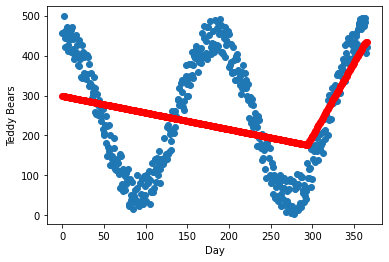

In [12]:
# Reset the model weights to the same as initialized
net.load_state_dict(torch.load('modelcheckpoint.pth'))

# Select our criterion (MSE Loss) and optimzer (SGD)
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Train network for 500 epochs and display the result
train(500, net, train_loader, val_loader, test_loader, criterion, optimizer)
displayResults(net, x, dayMin, dayMax, teddyBearsMin, teddyBearsMax, day, teddyBears)

## Select another Optimizer
The optimzer specifies the algorithm used to update the weights during training.   Sometimes, other optimizers will work better depending on the dataset and model.   Try to change the optimzier to adam with a learning rate of 0.01 and compare the training results with the above.


Epoch 100  Training Loss: 0.0659 Validation Loss: 0.0542
Epoch 200  Training Loss: 0.0644 Validation Loss: 0.0513
Epoch 300  Training Loss: 0.0626 Validation Loss: 0.0492
Epoch 400  Training Loss: 0.0636 Validation Loss: 0.0489
Epoch 500  Training Loss: 0.0078 Validation Loss: 0.0090
Final Average Test Dataset Loss:  0.0095


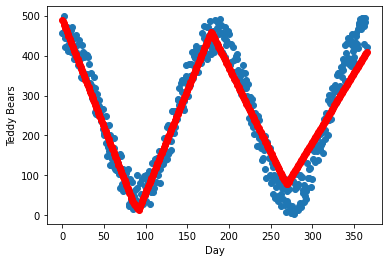

In [13]:
# Reset our weights to their original values
net.load_state_dict(torch.load('modelcheckpoint.pth'))

# Try with the Adam optimizer and a learning rate of 0.01
# Use the same criterion as above (MSE Loss)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train network and display result
train(500, net, train_loader, val_loader, test_loader, criterion, optimizer)
displayResults(net, x, dayMin, dayMax, teddyBearsMin, teddyBearsMax, day, teddyBears)

### Explore Different Models and Training Parameters
Now, explore different learning rates, models and optimizers.  Start by adjusting one slightly, then another and so on.  For example, what happens when you reduce the model's hidden units below 10?  What if you add another hidden layer?   Are you able to make the predicted (red) curve fit better by adjusting other values?

Epoch 100  Training Loss: 0.0047 Validation Loss: 0.0034
Epoch 200  Training Loss: 0.0038 Validation Loss: 0.0038
Epoch 300  Training Loss: 0.0045 Validation Loss: 0.0028
Epoch 400  Training Loss: 0.0037 Validation Loss: 0.0033
Epoch 500  Training Loss: 0.0056 Validation Loss: 0.0044
Final Average Test Dataset Loss:  0.0038


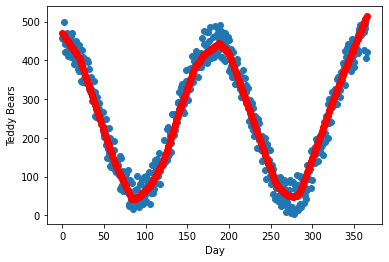

In [14]:
# Use a variable to define the number of hidden units in the hidden layer
numHiddenUnits = 100

class MyOwnModel(nn.Module):
    
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(1,numHiddenUnits)
            self.fc2 = nn.Linear(numHiddenUnits,numHiddenUnits)
            self.fc3 = nn.Linear(numHiddenUnits,1)
        
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

# Create an instance of the model and print out a model summary
net2 = MyOwnModel()

# Setup your training optimizer and specify your loss criteria
optimizer = torch.optim.Adam(net2.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train model using mini-batches and print out result
train(500, net2, train_loader, val_loader, test_loader, criterion, optimizer)
displayResults(net2, x, dayMin, dayMax, teddyBearsMin, teddyBearsMax, day, teddyBears)

### Key Takeaways

- You built a PyTorch deep neural network
- You trained the network and compared the ouput with the training set
- You experimented with different optimizers, learning rates and epochs

Congratulations on finishing the assingment!  Keep it going!